In [89]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset, get_dataset2
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils
from sklearn.cluster import KMeans,SpectralClustering
from scikit_posthocs import posthoc_dunn
import os
import zipfile

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#Imports to get rid of warnings
import warnings
from rdkit import RDLogger
import plotly.express as px
import scipy.stats as stats
RDLogger.DisableLog('rdApp.warning')
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

#Set a palette for all plots
sns.set_palette('Paired')


In [39]:
## function for scatterplot
def scatter_plot_with_log_ic50(df, x_col, title="Scatter Plot", x_label=None):
    """
    Plots a scatter plot of the specified column against Log(IC50).

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        x_col (str): The name of the column to use for the x-axis.
        title (str): The title of the plot (default is "Scatter Plot").
        x_label (str): Label for the x-axis (default is the column name).
    """
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_col], df['Log_IC50'], color="blue", alpha=0.6, label="Actual Data Points")
    
    # Add title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_label if x_label else x_col, fontsize=14)
    plt.ylabel("Log(IC50)", fontsize=14)
    
    # Add legend and grid
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Show the plot
    plt.show()

## linearity tests

The purpose of this notebook is to test whether the features from the rdkit expansion correlate with IC50. To do so, we import the dataset, add the rdkit features and convert them to numeric.

In [21]:
#import dataset
df_std = get_dataset()

In [23]:
# similar adjustment as we did in results.ipynb
hiv = df_std[df_std['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
hiv = data_utils.select_metric(hiv, 'IC50 (nM)')
hiv = data_utils.clean_na_columns(hiv)
hiv_condensed = evaluation_utils.group_similar_targets(hiv)

In [30]:
hivRD = hiv_condensed.copy()
hivRD = data_utils.nan_to_numeric(hivRD)
hivRD['Mol'] = hivRD['Ligand SMILES'].apply(rdkit_extraction.smiles_to_mol)

In [32]:
# Calculate descriptors and add them to the DataFrame
descriptor_df = hivRD['Mol'].apply(lambda mol: rdkit_extraction.calculate_descriptors(mol))
hivRD = pd.concat([hivRD, descriptor_df], axis=1)


In [52]:

numerical_df, non_numerical_df = data_utils.separe_num_df(hivRD)

# Apply log transformation to all numerical columns
# Add a small constant (e.g., 1e-9) to avoid log(0) or negative values
numerical_df = numerical_df.applymap(lambda x: np.log(x + 1e-9) if x > 0 else 0)

# Normalize the numerical data
numerical_df = (numerical_df - numerical_df.min()) / (numerical_df.max() - numerical_df.min())

# Drop the column with all 0-valued entries (if it exists)
if 'NumRadicalElectrons' in numerical_df.columns:
    numerical_df = numerical_df.drop(columns=['NumRadicalElectrons'])  # Drop if exists

# Combine back with non-numerical data if needed
processed_df = pd.concat([numerical_df, non_numerical_df], axis=1)

C:\Users\defer\AppData\Local\Temp\ipykernel_19932\3017246894.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Here we report some examples of scatterplots we plotted to see if there was correlation. In particular we tested the following features:
- *MolWt*: The molecular weight of the molecule, calculated as the sum of the atomic weights of all atoms present.
- *LogP*: The octanol-water partition coefficient (Log P), indicating the molecule's lipophilicity or hydrophobicity.
- *NumHDonors*: Number of hydrogen bond donors, typically counting hydrogen atoms attached to oxygen or nitrogen.
- *NumHAcceptors*: Number of hydrogen bond acceptors, such as oxygen or nitrogen atoms with lone pairs.
- *TPSA*: Topological Polar Surface Area, representing the surface area occupied by polar atoms; useful for predicting drug absorption.
- *NumRotatableBonds*: Number of rotatable bonds, affecting the molecule's flexibility.
- *NumAromaticRings*: Number of aromatic rings within the molecule.
- *NumAliphaticRings*: Number of aliphatic (non-aromatic) rings in the molecule.
- *FractionCSP3*: Fraction of sp³-hybridized carbons over total carbons, indicating the molecule's saturation level.
- *RingCount*: Total number of rings, both aromatic and aliphatic, present in the molecule.
- *FormalCharge*: The net formal charge of the molecule, calculated based on its electron configuration.
- *NumRadicalElectrons*: Number of unpaired (radical) electrons in the molecule.

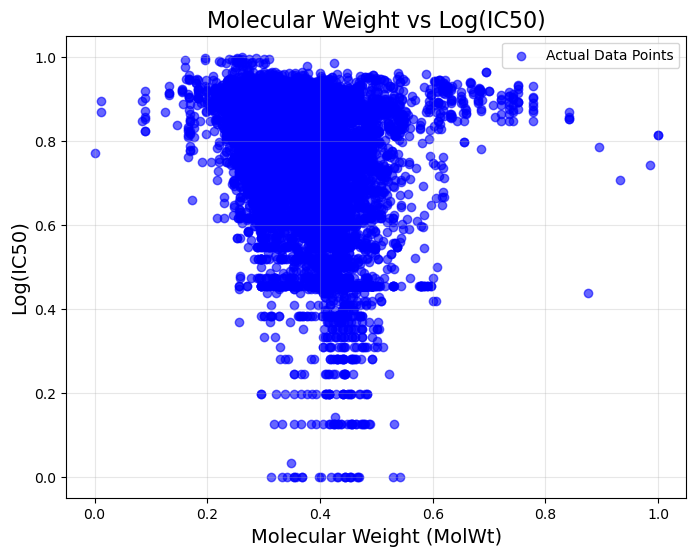

In [54]:
scatter_plot_with_log_ic50( numerical_df,x_col='MolWt',  title="Molecular Weight vs Log(IC50)", x_label="Molecular Weight (MolWt)")

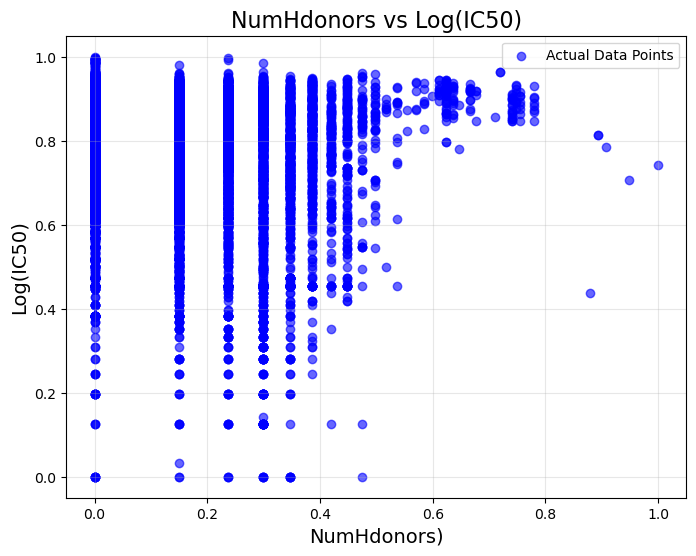

In [56]:
scatter_plot_with_log_ic50( numerical_df,x_col='NumHDonors',  title="NumHdonors vs Log(IC50)", x_label="NumHdonors)")

This was just to have a visual hint, in order to have a more quantitative analysis we performed a linear regression.


In [85]:
# Define X and y
X = numerical_df.drop(columns=['IC50 (nM)', 'Log_IC50', 'index', 'BindingDB Reactant_set_id', 'BindingDB MonomerID'])
y = numerical_df['IC50 (nM)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the indices to align them
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Add a constant to the features for the intercept term
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the OLS model
model = sm.OLS(y_train, X_train)
results = model.fit()

# Predict on the training set
ypr = results.predict(X_train)

# Display the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              IC50 (nM)   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     112.3
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:52:03   Log-Likelihood:                 5807.2
No. Observations:               11003   AIC:                        -1.156e+04
Df Residuals:                   10976   BIC:                        -1.136e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

From the R^2 and from some p_values we can already tell that the fetuares don't explain well the total variance. Still we tested it on the test set:

Test Set Evaluation Metrics:
Mean Squared Error (MSE): 0.02
Mean Absolute Error (MAE): 0.12
R-squared (R²): 0.21


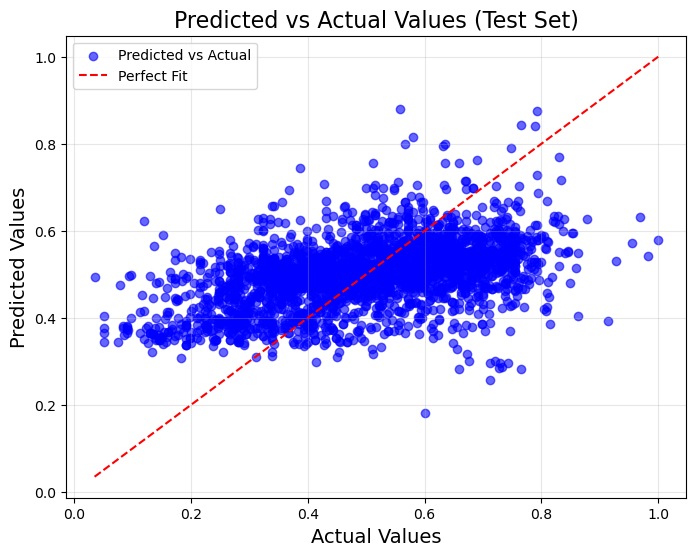

In [91]:
# Make predictions on the test set
y_pred_test = results.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

# Print the metrics
print("Test Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Visualize Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color="blue", alpha=0.6, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Perfect Fit")
plt.title("Predicted vs Actual Values (Test Set)", fontsize=16)
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

We can see that also on the test set the variance explained is very low. Therefore features of RDkit aren't predictive in a linear way of the IC50. The correlation might be in  a more complex pattern.